<a href="https://colab.research.google.com/github/paksi011/VGG16-noGAP1/blob/main/VGG16_NoGAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import os

In [ ]:
# =========================
# Image Transformations
# =========================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard for VGG16
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# =========================
# Custom Dataset Loader
# =========================
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root=root, transform=transform)
        self.classes = sorted(self.classes)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

    # Override method from ImageFolder
    @staticmethod
    def find_classes(directory):
        class_names = [entry.name for entry in os.scandir(directory) if entry.is_dir()]
        class_names = sorted(class_names)
        class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
        return class_names, class_to_idx

# =========================
# Dataset and DataLoader
# =========================
# Pastikan folder 'data/' berisi subfolder kelas dan gambar
dataset_path = '/content/drive/MyDrive/Dataset-augmentasi'  # Sesuaikan jika berbeda

# Cek apakah path ada
if not os.path.exists(dataset_path):
    print(f"Folder '{dataset_path}' tidak ditemukan. Upload folder ke Colab terlebih dahulu.")

else:
    dataset = CustomImageFolder(root=dataset_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=0)

    # =========================
    # Cek Data
    # =========================
    print("Class names:", dataset.classes)
    for images, labels in dataloader:
        print(f'Batch of images: {images.shape}')
        print(f'Batch of labels: {labels.shape}')
        break

Class names: ['Demas 1', 'Dena 1', 'Denasa 2', 'Derap 1', 'Dering 3', 'Detap 1', 'Devatra 1', 'Devatra 2', 'Devon 1', 'Gepak Kuning']
Batch of images: torch.Size([8, 3, 224, 224])
Batch of labels: torch.Size([8])


In [ ]:
# =========================
# Hitung Jumlah Kelas
# =========================
num_classes = len(dataset.classes)  # dataset dari langkah sebelumnya

# =========================
# Load Pretrained VGG16 (default weights)
# =========================
vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# =========================
# Freeze Semua Layer
# =========================
for param in vgg16.parameters():
    param.requires_grad = False

# =========================
# Ganti Layer Terakhir dari Classifier
# (Tanpa mengubah arsitektur asli VGG16)
# =========================
vgg16.classifier[6] = nn.Linear(4096, num_classes)

# =========================
# Unfreeze Hanya Layer Classifier
# =========================
for param in vgg16.classifier.parameters():
    param.requires_grad = True

# =========================
# (Optional) Fine-tune beberapa conv layer terakhir
# =========================
for param in vgg16.features[24:].parameters():
    param.requires_grad = True

# =========================
# Kirim ke Device
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

# =========================
# Tampilkan Struktur Model
# =========================
print(vgg16)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 164MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# training set up
criterion = nn.CrossEntropyLoss()

# Optimizer (hanya update parameter yang boleh di-train)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vgg16.parameters()), lr=0.0001)

# Learning rate scheduler (turunkan setiap 5 epoch)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
from datetime import datetime
from tqdm import tqdm

# Early stopping setup
early_stopping_patience = 5
best_acc = 0
epochs_since_last_improvement = 0

# Epoch settings
num_epochs = 10
losses, accuracies, timestamps, epoch_durations = [], [], [], []

for epoch in range(num_epochs):
    vgg16.train()
    running_loss, correct, total = 0.0, 0, 0
    start_time = datetime.now()

    # Progress bar per epoch
    for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Metrics
    avg_loss = running_loss / len(dataloader)
    accuracy = 100 * correct / total
    duration = (datetime.now() - start_time).total_seconds()

    losses.append(avg_loss)
    accuracies.append(accuracy)
    timestamps.append(start_time.strftime('%Y-%m-%d %H:%M:%S'))
    epoch_durations.append(duration)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Acc: {accuracy:.2f}% | Time: {duration:.1f}s")

    scheduler.step()

    # Save best model
    if accuracy > best_acc:
        best_acc = accuracy
        epochs_since_last_improvement = 0
        torch.save(vgg16.state_dict(), 'best_model.pth')
    else:
        epochs_since_last_improvement += 1

    # Early stopping
    if epochs_since_last_improvement >= early_stopping_patience:
        print(f"Early stopping: no improvement for {early_stopping_patience} epochs.")
        break

    torch.cuda.empty_cache()

Epoch 1/10: 100%|██████████| 375/375 [04:33<00:00,  1.37it/s]


Epoch 1/10 | Loss: 1.3770 | Acc: 47.07% | Time: 273.2s


Epoch 2/10: 100%|██████████| 375/375 [04:30<00:00,  1.39it/s]


Epoch 2/10 | Loss: 0.6531 | Acc: 74.80% | Time: 270.4s


Epoch 3/10: 100%|██████████| 375/375 [04:31<00:00,  1.38it/s]


Epoch 3/10 | Loss: 0.4215 | Acc: 84.83% | Time: 271.8s


Epoch 4/10: 100%|██████████| 375/375 [04:26<00:00,  1.41it/s]


Epoch 4/10 | Loss: 0.3564 | Acc: 86.87% | Time: 266.3s


Epoch 5/10: 100%|██████████| 375/375 [04:28<00:00,  1.40it/s]


Epoch 5/10 | Loss: 0.2583 | Acc: 91.30% | Time: 268.1s


Epoch 6/10: 100%|██████████| 375/375 [04:24<00:00,  1.42it/s]


Epoch 6/10 | Loss: 0.1058 | Acc: 96.13% | Time: 264.2s


Epoch 7/10: 100%|██████████| 375/375 [04:20<00:00,  1.44it/s]


Epoch 7/10 | Loss: 0.0668 | Acc: 97.60% | Time: 260.7s


Epoch 8/10: 100%|██████████| 375/375 [04:20<00:00,  1.44it/s]


Epoch 8/10 | Loss: 0.0511 | Acc: 98.27% | Time: 260.2s


Epoch 9/10: 100%|██████████| 375/375 [04:20<00:00,  1.44it/s]


Epoch 9/10 | Loss: 0.0466 | Acc: 98.33% | Time: 260.6s


Epoch 10/10: 100%|██████████| 375/375 [04:24<00:00,  1.42it/s]

Epoch 10/10 | Loss: 0.0488 | Acc: 98.23% | Time: 264.7s


In [ ]:
vgg16.eval()

correct = 0
total = 0

# Matikan gradient tracking karena tidak diperlukan saat evaluasi
with torch.no_grad():
    for inputs, labels in dataloader:
        # Pindahkan ke device (bisa CPU atau GPU tergantung device sebelumnya)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = vgg16(inputs)

        # Ambil prediksi kelas tertinggi
        _, predicted = torch.max(outputs, 1)

        # Hitung akurasi
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung persentase akurasi
accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy:.2f}%', flush=True)

Accuracy on the test set: 98.80%


In [ ]:
!pip install matplotlib


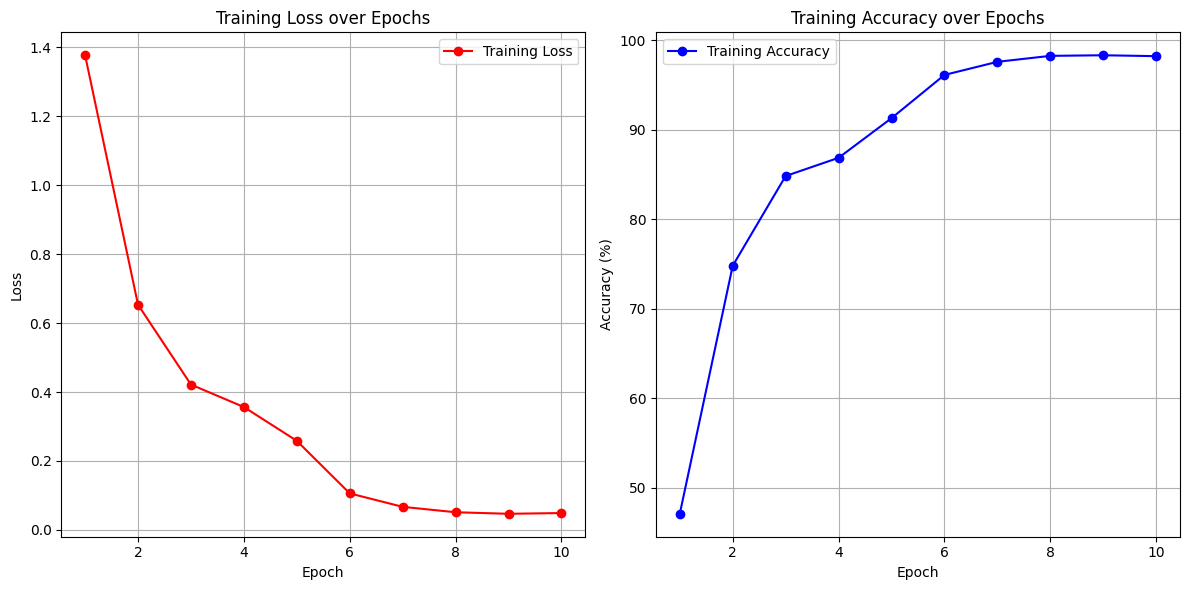

In [ ]:
import matplotlib.pyplot as plt
# =========================
# Plotting Training Curves
# =========================
plt.figure(figsize=(12, 6))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss', color='red', marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies, label='Training Accuracy', color='blue', marker='o')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
from torchvision import models
import torch.nn as nn

# Gunakan CPU jika tidak ada GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

# Pastikan dataset sudah didefinisikan
num_classes = len(dataset.classes)

# Inisialisasi ulang arsitektur model VGG16
vgg16_loaded = models.vgg16(pretrained=False)
vgg16_loaded.avgpool = nn.AdaptiveAvgPool2d(1)
vgg16_loaded.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(4096, num_classes)
)

# Pindahkan model ke device (CPU/GPU)
vgg16_loaded = vgg16_loaded.to(device)

# Load bobot model terbaik
model_path = "best_model.pth"
if torch.cuda.is_available():
    vgg16_loaded.load_state_dict(torch.load(model_path))
else:
    vgg16_loaded.load_state_dict(torch.load(model_path, map_location=device))

# Set model ke mode evaluasi
vgg16_loaded.eval()

# =========================
# Evaluasi Model
# =========================
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in dataloader:  # Gunakan dataloader validasi/test
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16_loaded(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Hitung akurasi
accuracy = 100 * correct / total
print(f'Accuracy of loaded VGG16 model on the dataset: {accuracy:.2f}%')

Device used: cuda


RuntimeError: Error(s) in loading state_dict for VGG:
	Missing key(s) in state_dict: "classifier.1.weight", "classifier.1.bias", "classifier.4.weight", "classifier.4.bias", "classifier.7.weight", "classifier.7.bias". 
	Unexpected key(s) in state_dict: "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 

Device used: cuda
Found classes: ['Demas 1', 'Dena 1', 'Denasa 2', 'Derap 1', 'Dering 3', 'Detap 1', 'Devatra 1', 'Devatra 2', 'Devon 1', 'Gepak Kuning']


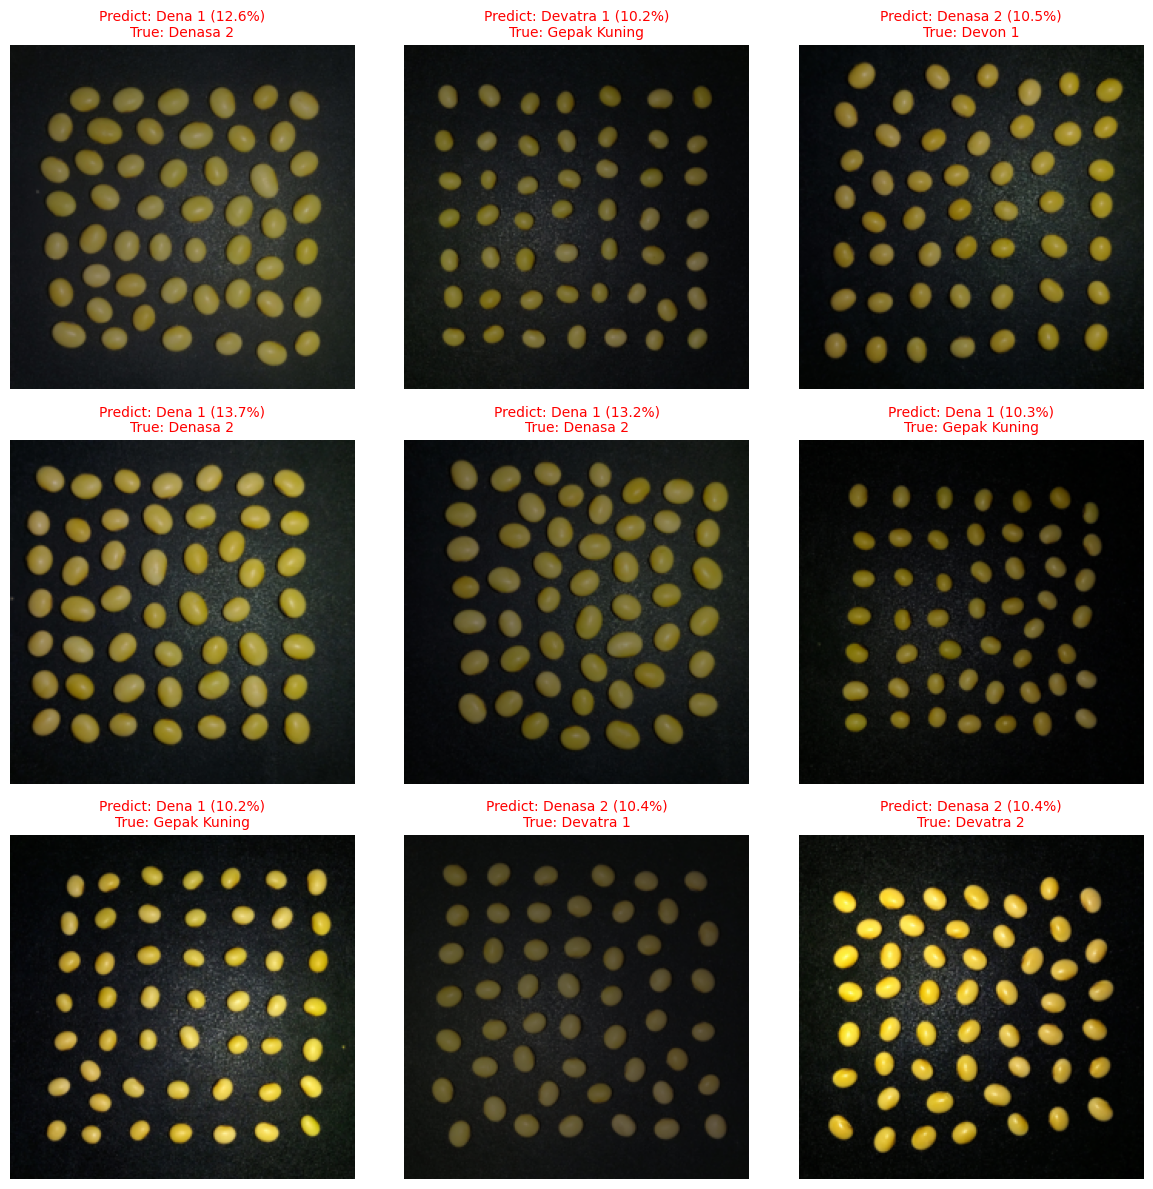

In [ ]:
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import torch

# ====== Device Setup ======
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device used: {device}")

# ====== Path ke Folder Dataset di Google Drive ======
# Ganti sesuai lokasi aktual dataset kamu di Google Drive
data_dir = '/content/drive/MyDrive/Dataset-augmentasi'

# Validasi folder
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Folder tidak ditemukan: {data_dir}")

# ====== Class Names (sorted by folder names inside 'data') ======
class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
print(f"Found classes: {class_names}")

# ====== Transform (should match training pipeline) ======
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ====== Select 9 Random Images from Random Classes ======
samples = []
for _ in range(9):
    chosen_class = random.choice(class_names)
    class_dir = os.path.join(data_dir, chosen_class)
    all_imgs = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not all_imgs:
        continue  # skip if no image found
    chosen_img = random.choice(all_imgs)
    img_path = os.path.join(class_dir, chosen_img)
    samples.append((img_path, chosen_class))

# If fewer than 9 samples were found (e.g., some folders are empty), pad with repeats
while len(samples) < 9 and samples:
    samples.append(random.choice(samples))

if not samples:
    raise RuntimeError("Tidak ada gambar yang ditemukan di folder dataset!")

# ====== Pastikan Model Sudah Diload ======
# Harus sudah ada vgg16_loaded sebelumnya dan berada di eval mode
try:
    vgg16_loaded.eval()
except NameError:
    raise NameError("Model 'vgg16_loaded' belum didefinisikan. Pastikan kamu sudah load model sebelum menjalankan ini.")

# ====== Plot 3x3 Predictions ======
plt.figure(figsize=(12, 12))

for idx, (img_path, true_class) in enumerate(samples):
    # Load and preprocess image
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = vgg16_loaded(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, pred_idx = torch.max(probs, 1)
        pred_class = class_names[pred_idx.item()]
        confidence_val = confidence.item()

    # Unnormalize for display
    img_disp = img_tensor.cpu().squeeze().numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_disp = std * img_disp + mean
    img_disp = np.clip(img_disp, 0, 1)

    # Set title color based on prediction
    color = 'green' if pred_class == true_class else 'red'

    # Plot
    plt.subplot(3, 3, idx + 1)
    plt.imshow(img_disp)
    plt.title(f"Predict: {pred_class} ({confidence_val*100:.1f}%)\nTrue: {true_class}", fontsize=10, color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()